# Locality-Controlled Benchmarking: Classical Shadows vs Baselines

This notebook extends `notebook_j` to study how **observable locality (Pauli weight K)** affects
the relative performance of classical shadows vs direct measurement baselines.

**Key Question:** At what locality K does classical shadows start to lose its advantage?

**Theory Reminder:**
- Shadows variance scales as `3^K` for weight-K observables
- Direct measurement variance is independent of K (same circuit per observable)
- Shadows should dominate at low K, baselines at high K

**Parameters:**
- `LOCALITY_K`: The Pauli weight of observables (1 = single-qubit, 2 = two-qubit, etc.)
- All observables have exactly weight K

In [1]:
# --- Setup and imports ---
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, '../src')

from qiskit import QuantumCircuit

from quartumse.benchmarking import run_publication_benchmark
from quartumse.observables import Observable, ObservableSet, generate_observable_set
from quartumse.protocols import DirectNaiveProtocol, DirectGroupedProtocol, DirectOptimizedProtocol
from quartumse.protocols.shadows import ShadowsV0Protocol
from quartumse.tasks import (
    TaskConfig, TaskType, CriterionType,
    WorstCaseTask, AverageTargetTask, FixedBudgetDistributionTask,
    DominanceTask, PilotSelectionTask, BiasVarianceTask,
)
from quartumse.io import ParquetWriter

## 1. Configuration

**Key parameter: `LOCALITY_K`** - controls the Pauli weight of all observables.

| K | Example Observables | Shadows Variance Factor |
|---|---------------------|------------------------|
| 1 | X, Y, Z on single qubit | 3^1 = 3 |
| 2 | XX, XY, ZZ on two qubits | 3^2 = 9 |
| 3 | XXX, XYZ, ZZZ on three qubits | 3^3 = 27 |
| 4 | XXXX, ZZZZ on four qubits | 3^4 = 81 |

In [ ]:
# =============================================================================
# KEY PARAMETER: Set the locality (Pauli weight) of observables
# =============================================================================
LOCALITY_K = 1  # Change this to 1, 2, 3, or 4

# --- Other configuration ---
SEED = 42
N_QUBITS = 4
N_SHOTS_GRID = [100, 500, 1000, 5000]
N_REPLICATES = 20
EPSILON = 0.01
DELTA = 0.05

# Validate locality
assert 1 <= LOCALITY_K <= N_QUBITS, f"LOCALITY_K must be between 1 and {N_QUBITS}"

# Auto-adjust N_OBSERVABLES to not exceed maximum possible unique observables
# Max unique weight-K Paulis = 3^K * C(n_qubits, K)
from math import comb
MAX_POSSIBLE_OBSERVABLES = (3 ** LOCALITY_K) * comb(N_QUBITS, LOCALITY_K)
N_OBSERVABLES_REQUESTED = 24
N_OBSERVABLES = min(N_OBSERVABLES_REQUESTED, MAX_POSSIBLE_OBSERVABLES)

# Output directory with timestamp (format: name_D_M_YYYY_HHMM)
from datetime import datetime
now = datetime.now()
timestamp = f"{now.day}_{now.month}_{now.year}_{now.hour:02d}{now.minute:02d}"
OUTPUT_DIR = Path(f'results/locality_k{LOCALITY_K}_benchmark_{timestamp}')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Benchmarking with LOCALITY K = {LOCALITY_K}")
print(f"Expected shadows variance factor: 3^{LOCALITY_K} = {3**LOCALITY_K}")
print(f"Max possible weight-{LOCALITY_K} observables: {MAX_POSSIBLE_OBSERVABLES}")
print(f"Using N_OBSERVABLES = {N_OBSERVABLES}" + (f" (capped from {N_OBSERVABLES_REQUESTED})" if N_OBSERVABLES < N_OBSERVABLES_REQUESTED else ""))
print(f"Output directory: {OUTPUT_DIR}")

## 2. GHZ Circuit (4 qubits)

We use the same GHZ circuit as notebook_j for consistency.

In [3]:
def build_ghz(n_qubits: int) -> QuantumCircuit:
    """Build a GHZ state preparation circuit."""
    qc = QuantumCircuit(n_qubits)
    qc.h(0)
    for i in range(1, n_qubits):
        qc.cx(i - 1, i)
    return qc

ghz_circuit = build_ghz(N_QUBITS)
print(ghz_circuit.draw('text'))

     ┌───┐               
q_0: ┤ H ├──■────────────
     └───┘┌─┴─┐          
q_1: ─────┤ X ├──■───────
          └───┘┌─┴─┐     
q_2: ──────────┤ X ├──■──
               └───┘┌─┴─┐
q_3: ───────────────┤ X ├
                    └───┘


## 3. Generate Fixed-Locality Observable Set

All observables will have exactly weight K (LOCALITY_K non-identity Paulis).

In [4]:
def generate_fixed_locality_observables(
    n_qubits: int,
    locality_k: int,
    n_observables: int,
    seed: int,
) -> ObservableSet:
    """Generate observables with exactly weight K.
    
    Args:
        n_qubits: Number of qubits
        locality_k: Exact Pauli weight (number of non-identity operators)
        n_observables: Number of observables to generate
        seed: Random seed
        
    Returns:
        ObservableSet with all observables having weight = locality_k
    """
    obs_set = generate_observable_set(
        generator_id='random_pauli',
        n_qubits=n_qubits,
        n_observables=n_observables,
        seed=seed,
        weight_distribution='fixed',
        fixed_weight=locality_k,
    )
    return obs_set


def get_all_weight_k_paulis(n_qubits: int, k: int) -> list[str]:
    """Generate all possible weight-K Pauli strings (for small K).
    
    Useful for exhaustive testing at low K.
    """
    from itertools import combinations, product
    
    paulis = []
    pauli_ops = ['X', 'Y', 'Z']
    
    # All ways to choose K positions from n_qubits
    for positions in combinations(range(n_qubits), k):
        # All ways to assign X, Y, Z to those positions
        for ops in product(pauli_ops, repeat=k):
            pauli_list = ['I'] * n_qubits
            for pos, op in zip(positions, ops):
                pauli_list[pos] = op
            paulis.append(''.join(pauli_list))
    
    return paulis


# Generate the observable set
obs_set = generate_fixed_locality_observables(
    n_qubits=N_QUBITS,
    locality_k=LOCALITY_K,
    n_observables=N_OBSERVABLES,
    seed=SEED,
)

# Update metadata
obs_set = ObservableSet(
    observables=list(obs_set.observables),
    observable_set_id=f'fixed_locality_k{LOCALITY_K}',
    generator_id='random_pauli_fixed_weight',
    generator_seed=SEED,
    generator_params={
        'n_qubits': N_QUBITS,
        'n_observables': N_OBSERVABLES,
        'locality_k': LOCALITY_K,
    },
)

print(f"Generated {len(obs_set)} observables with locality K = {LOCALITY_K}")
print(f"\nFirst 10 observables:")
for i, obs in enumerate(list(obs_set.observables)[:10]):
    weight = sum(1 for c in obs.pauli_string if c != 'I')
    print(f"  {i+1}. {obs.pauli_string} (weight={weight})")

# Verify all have correct weight
weights = [sum(1 for c in obs.pauli_string if c != 'I') for obs in obs_set.observables]
assert all(w == LOCALITY_K for w in weights), "Not all observables have correct weight!"
print(f"\nVerified: All observables have weight = {LOCALITY_K}")

Generated 12 observables with locality K = 1

First 10 observables:
  1. ZIII (weight=1)
  2. IIYI (weight=1)
  3. IZII (weight=1)
  4. XIII (weight=1)
  5. IIZI (weight=1)
  6. IIXI (weight=1)
  7. IIIY (weight=1)
  8. IXII (weight=1)
  9. YIII (weight=1)
  10. IIIX (weight=1)

Verified: All observables have weight = 1


## 4. Protocols Under Test

In [5]:
protocols = [
    DirectNaiveProtocol(),
    DirectGroupedProtocol(),
    DirectOptimizedProtocol(),
    ShadowsV0Protocol(),
]

print("Protocols:")
for p in protocols:
    print(f"  - {p.protocol_id}")

Protocols:
  - direct_naive
  - direct_grouped
  - direct_optimized
  - classical_shadows_v0


## 5. Run Publication Benchmark

In [6]:
results = run_publication_benchmark(
    circuit=ghz_circuit,
    observable_set=obs_set,
    protocols=protocols,
    n_shots_grid=N_SHOTS_GRID,
    n_replicates=N_REPLICATES,
    seed=SEED,
    output_dir=str(OUTPUT_DIR),
    epsilon=EPSILON,
    delta=DELTA,
)

print(f"\nBenchmark completed: {results['summary']['run_id']}")
print(f"Long-form rows: {results['summary']['n_long_form_rows']}")


Benchmark completed: publication_benchmark_8edd16d8
Long-form rows: 3840


## 6. Results Summary

In [7]:
import pandas as pd

# Extract protocol summaries
protocol_summaries = results['protocol_summaries']

# Create comparison table
summary_data = []
for protocol_id, stats in protocol_summaries.items():
    summary_data.append({
        'Protocol': protocol_id,
        'Mean SE': f"{stats['mean_se']:.4f}",
        'Median SE': f"{stats['median_se']:.4f}",
        'Max SE': f"{stats['max_se']:.4f}",
        'Mean |Error|': f"{stats['mean_abs_error']:.4f}",
        'Max |Error|': f"{stats['max_abs_error']:.4f}",
    })

df = pd.DataFrame(summary_data)
print(f"\n=== Results for LOCALITY K = {LOCALITY_K} ===")
print(f"(Shadows variance factor: 3^{LOCALITY_K} = {3**LOCALITY_K})\n")
print(df.to_string(index=False))

# Highlight winner
shadows_mean_se = float(protocol_summaries['classical_shadows_v0']['mean_se'])
grouped_mean_se = float(protocol_summaries['direct_grouped']['mean_se'])

print(f"\n--- Comparison: Shadows vs Grouped ---")
print(f"Shadows mean SE:  {shadows_mean_se:.4f}")
print(f"Grouped mean SE:  {grouped_mean_se:.4f}")
if shadows_mean_se < grouped_mean_se:
    improvement = (grouped_mean_se - shadows_mean_se) / grouped_mean_se * 100
    print(f"Winner: SHADOWS ({improvement:.1f}% better)")
else:
    degradation = (shadows_mean_se - grouped_mean_se) / grouped_mean_se * 100
    print(f"Winner: GROUPED (shadows {degradation:.1f}% worse)")


=== Results for LOCALITY K = 1 ===
(Shadows variance factor: 3^1 = 3)

            Protocol Mean SE Median SE Max SE Mean |Error| Max |Error|
        direct_naive  0.0490    0.0491 0.0491       0.0382      0.1683
      direct_grouped  0.0245    0.0245 0.0245       0.0193      0.0636
    direct_optimized  0.0245    0.0245 0.0245       0.0218      0.0779
classical_shadows_v0  0.0245    0.0245 0.0253       0.0215      0.0672

--- Comparison: Shadows vs Grouped ---
Shadows mean SE:  0.0245
Grouped mean SE:  0.0245
Winner: SHADOWS (0.0% better)


## 7. Task Analysis

In [8]:
long_form_rows = results['long_form_results']
truth_values = results['ground_truth'].truth_values if results['ground_truth'] else {}

# Task 4: Dominance analysis
task4 = DominanceTask(TaskConfig(
    task_id='task4_dominance',
    task_type=TaskType.DOMINANCE,
    epsilon=EPSILON,
    delta=DELTA,
    n_grid=N_SHOTS_GRID,
    criterion_type=CriterionType.TRUTH_BASED,
))

rows_shadows = [r for r in long_form_rows if r.protocol_id == 'classical_shadows_v0']
rows_grouped = [r for r in long_form_rows if r.protocol_id == 'direct_grouped']

dominance = task4.compare_protocols(rows_shadows, rows_grouped, truth_values, metric='mean_se')

print(f"\n=== Dominance Analysis (K={LOCALITY_K}) ===")
print(f"Metric: mean_se")
print(f"Crossover N: {dominance['crossover_n']}")
print(f"Shadows wins at N: {dominance['a_dominates_at']}")
print(f"Grouped wins at N: {dominance['b_dominates_at']}")
print(f"Always shadows better: {dominance['always_a_better']}")
print(f"Always grouped better: {dominance['always_b_better']}")

if dominance['blocking_observables']:
    print(f"Blocking observables ({len(dominance['blocking_observables'])}): {dominance['blocking_observables'][:5]}...")


=== Dominance Analysis (K=1) ===
Metric: mean_se
Crossover N: None
Shadows wins at N: [100, 500, 1000, 5000]
Grouped wins at N: []
Always shadows better: True
Always grouped better: False


## 8. Visualization: SE vs Shots by Protocol

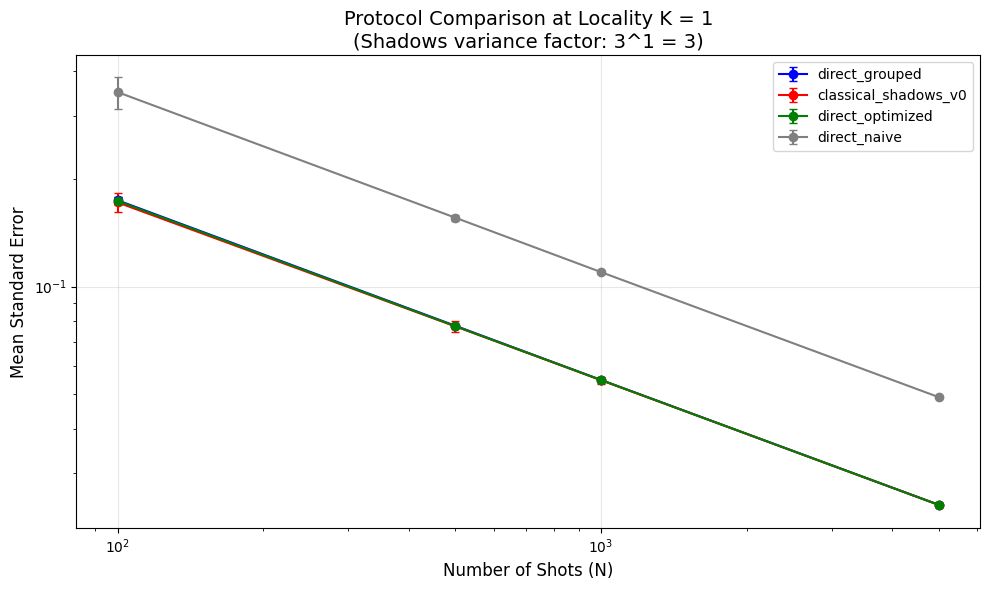


Plot saved to: results\locality_k1_benchmark\se_vs_shots_k1.png


In [9]:
from collections import defaultdict

# Compute mean SE at each N for each protocol
se_by_protocol_n = defaultdict(lambda: defaultdict(list))

for row in long_form_rows:
    se_by_protocol_n[row.protocol_id][row.N_total].append(row.se)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

colors = {
    'direct_naive': 'gray',
    'direct_grouped': 'blue',
    'direct_optimized': 'green',
    'classical_shadows_v0': 'red',
}

for protocol_id in ['direct_grouped', 'classical_shadows_v0', 'direct_optimized', 'direct_naive']:
    ns = sorted(se_by_protocol_n[protocol_id].keys())
    mean_ses = [np.mean(se_by_protocol_n[protocol_id][n]) for n in ns]
    std_ses = [np.std(se_by_protocol_n[protocol_id][n]) for n in ns]
    
    ax.errorbar(ns, mean_ses, yerr=std_ses, marker='o', label=protocol_id,
                color=colors.get(protocol_id, 'black'), capsize=3)

ax.set_xlabel('Number of Shots (N)', fontsize=12)
ax.set_ylabel('Mean Standard Error', fontsize=12)
ax.set_title(f'Protocol Comparison at Locality K = {LOCALITY_K}\n(Shadows variance factor: 3^{LOCALITY_K} = {3**LOCALITY_K})', fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / f'se_vs_shots_k{LOCALITY_K}.png', dpi=150)
plt.show()

print(f"\nPlot saved to: {OUTPUT_DIR / f'se_vs_shots_k{LOCALITY_K}.png'}")

## 9. (Optional) Run Sweep Across All Localities

Uncomment and run the cell below to benchmark across K=1,2,3,4 and compare.

In [10]:
# # Uncomment to run full locality sweep
# 
# locality_results = {}
# 
# for k in [1, 2, 3, 4]:
#     print(f"\n{'='*60}")
#     print(f"Running benchmark for K = {k}")
#     print(f"{'='*60}")
#     
#     # Auto-adjust observables for this K
#     max_possible_k = (3 ** k) * comb(N_QUBITS, k)
#     n_obs_k = min(N_OBSERVABLES_REQUESTED, max_possible_k)
#     print(f"Max possible observables: {max_possible_k}, using: {n_obs_k}")
#     
#     # Generate observables for this K
#     k_obs_set = generate_fixed_locality_observables(
#         n_qubits=N_QUBITS,
#         locality_k=k,
#         n_observables=n_obs_k,
#         seed=SEED,
#     )
#     
#     k_output_dir = Path(f'results/locality_sweep_k{k}')
#     k_output_dir.mkdir(parents=True, exist_ok=True)
#     
#     k_results = run_publication_benchmark(
#         circuit=ghz_circuit,
#         observable_set=k_obs_set,
#         protocols=protocols,
#         n_shots_grid=N_SHOTS_GRID,
#         n_replicates=N_REPLICATES,
#         seed=SEED,
#         output_dir=str(k_output_dir),
#         epsilon=EPSILON,
#         delta=DELTA,
#     )
#     
#     locality_results[k] = k_results['protocol_summaries']
# 
# # Summary table
# print("\n" + "="*80)
# print("LOCALITY SWEEP SUMMARY")
# print("="*80)
# 
# summary_rows = []
# for k in [1, 2, 3, 4]:
#     shadows_se = locality_results[k]['classical_shadows_v0']['mean_se']
#     grouped_se = locality_results[k]['direct_grouped']['mean_se']
#     ratio = shadows_se / grouped_se
#     winner = 'Shadows' if ratio < 1 else 'Grouped'
#     
#     summary_rows.append({
#         'K': k,
#         'Variance Factor': f'3^{k}={3**k}',
#         'Shadows SE': f'{shadows_se:.4f}',
#         'Grouped SE': f'{grouped_se:.4f}',
#         'Ratio (S/G)': f'{ratio:.2f}',
#         'Winner': winner,
#     })
# 
# sweep_df = pd.DataFrame(summary_rows)
# print(sweep_df.to_string(index=False))

## 10. Conclusions

In [11]:
print(f"\n{'='*60}")
print(f"CONCLUSIONS FOR LOCALITY K = {LOCALITY_K}")
print(f"{'='*60}")
print(f"")
print(f"Configuration:")
print(f"  - Circuit: {N_QUBITS}-qubit GHZ")
print(f"  - Observables: {N_OBSERVABLES} random Paulis with weight = {LOCALITY_K}")
print(f"  - Shot grid: {N_SHOTS_GRID}")
print(f"  - Replicates: {N_REPLICATES}")
print(f"")
print(f"Theory:")
print(f"  - Shadows variance factor: 3^{LOCALITY_K} = {3**LOCALITY_K}")
print(f"  - Higher K -> higher shadows variance -> baselines more competitive")
print(f"")
print(f"Results:")
print(f"  - Shadows mean SE: {shadows_mean_se:.4f}")
print(f"  - Grouped mean SE: {grouped_mean_se:.4f}")
print(f"  - Ratio (Shadows/Grouped): {shadows_mean_se/grouped_mean_se:.2f}")
print(f"")

if shadows_mean_se < grouped_mean_se:
    print(f"  SHADOWS WINS at K={LOCALITY_K}")
    print(f"  -> Low locality favors shadows (reuse of measurement data)")
else:
    print(f"  GROUPED WINS at K={LOCALITY_K}")
    print(f"  -> High locality favors direct measurement (lower variance per shot)")

print(f"")
print(f"Artifacts saved to: {OUTPUT_DIR}")


CONCLUSIONS FOR LOCALITY K = 1

Configuration:
  - Circuit: 4-qubit GHZ
  - Observables: 12 random Paulis with weight = 1
  - Shot grid: [100, 500, 1000, 5000]
  - Replicates: 20

Theory:
  - Shadows variance factor: 3^1 = 3
  - Higher K -> higher shadows variance -> baselines more competitive

Results:
  - Shadows mean SE: 0.0245
  - Grouped mean SE: 0.0245
  - Ratio (Shadows/Grouped): 1.00

  SHADOWS WINS at K=1
  -> Low locality favors shadows (reuse of measurement data)

Artifacts saved to: results\locality_k1_benchmark


In [12]:
# Save final report
report_path = OUTPUT_DIR / 'locality_report.md'

report = f"""# Locality Benchmark Report (K={LOCALITY_K})

## Configuration
- Locality K: {LOCALITY_K}
- Variance factor: 3^{LOCALITY_K} = {3**LOCALITY_K}
- Circuit: {N_QUBITS}-qubit GHZ
- Observables: {N_OBSERVABLES}
- Shot grid: {N_SHOTS_GRID}
- Replicates: {N_REPLICATES}

## Results

| Protocol | Mean SE | Median SE | Max SE |
|----------|---------|-----------|--------|
"""

for protocol_id, stats in protocol_summaries.items():
    report += f"| {protocol_id} | {stats['mean_se']:.4f} | {stats['median_se']:.4f} | {stats['max_se']:.4f} |\n"

report += f"""
## Dominance Analysis
- Crossover N: {dominance['crossover_n']}
- Shadows wins at: {dominance['a_dominates_at']}
- Grouped wins at: {dominance['b_dominates_at']}

## Conclusion
At locality K={LOCALITY_K}, {'**SHADOWS**' if shadows_mean_se < grouped_mean_se else '**GROUPED**'} performs better.
"""

report_path.write_text(report, encoding='utf-8')
print(f"Report saved to: {report_path}")

Report saved to: results\locality_k1_benchmark\locality_report.md
